#### Chest X-Ray Images (Pneumonia)

URL: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [20]:
import os
import skimage
import numpy as np
from skimage.transform import resize
from PIL import Image
from keras.utils import to_categorical

In [2]:
def get_x_y(type_dataset, type_label):
    x = []
    path = './datasets/' + type_dataset + "/" + type_label + "/"
    files = os.listdir(path)
    for file in files:
        if os.path.splitext(path + file)[1] == '.jpeg':
            img = np.array(Image.open(path + file))
            img = np.asarray(skimage.transform.resize(img, (150, 150, 3)))
            x.append(img)
    x = np.asarray(x)
    y = np.zeros(x.shape[0]) if type_label == 'NORMAL' else np.ones(x.shape[0])
    return x, y


In [11]:
def get_shuffled_x_y(type_dataset):
    train_normal_x, train_normal_y = get_x_y(type_dataset, 'NORMAL')
    train_pneumonia_x, train_pneumonia_y = get_x_y(type_dataset, 'PNEUMONIA')
    x = np.concatenate([train_normal_x, train_pneumonia_x])
    #y = np.concatenate([train_normal_y, train_pneumonia_y])
    y = to_categorical(np.concatenate([train_normal_y, train_pneumonia_y]))
    shuffle = np.arange(x.shape[0])
    np.random.shuffle(shuffle)
    x = x[shuffle]
    y = y[shuffle]
    return x, y


In [12]:
x_train, y_train = get_shuffled_x_y('train')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
x_test, y_test = get_shuffled_x_y('test')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
x_val, y_val = get_shuffled_x_y('val')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [21]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras import regularizers

import sys
sys.path.insert(0, '../../Utils')
from fnn_helper import PlotLosses

In [19]:
print(y_val[2])
print(np.argmax(y_val[2], axis=None, out=None))

[0. 1.]
1


In [9]:
dropout = 0.25
regularizer = 0.01

model = Sequential()
model.add(Convolution2D(filters=6, strides=1, kernel_size=6, padding='same',input_shape=(150,150,3), kernel_regularizer=regularizers.l2(regularizer)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=12, strides=2, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(regularizer)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=24, strides=2, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(regularizer)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(200, kernel_regularizer=regularizers.l2(regularizer)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(regularizer)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 6)       654       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 6)       24        
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 6)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 12)        1812      
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 12)        48        
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 12)        0         
__________

In [10]:
lr = 0.0001
plot_interval = 1
epochs = 80
batch_size = 1024

adam = optimizers.Adam(lr=lr)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='Test4-Regularizer.weights.best.hdf5', verbose=1, save_best_only=True)
plot_losses = PlotLosses(plot_interval=plot_interval, evaluate_interval=None, x_val=x_test, y_val_categorical=y_test)

model.fit(x_train, 
          y_train,
          epochs=epochs, 
          batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[plot_losses, 
                     checkpointer],
         )

ValueError: Error when checking target: expected dense_2 to have shape (2,) but got array with shape (1,)

In [14]:
model.load_weights('Test4-Regularizer.weights.best.hdf5')
score = model.evaluate(x_val, y_val, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.64446803703395
accuracy:  0.9020501140309901


In [36]:
x_val_predict = model.predict_classes(x_val)

In [38]:
print(x_val_predict[0])
print(y_val[0])

1
[0. 1.]


In [21]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_val)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_val,axis = 1)


CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(5, 5))
plt.show()

NameError: name 'np' is not defined

In [91]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def inverse_to_categorical(val):
    return np.argmax(val, axis=None, out=None)

def plot_confusion_matrix(predict_values, real_values):
    matrix = np.zeros([2, 2])
    for i in range(predict_values.shape[0]):
        true_y = inverse_to_categorical(real_values[i])
        predict_y = predict_values[i]
        matrix[true_y][predict_y] = matrix[true_y][predict_y] + 1
    
    df_cm = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, cmap="Blues", linewidths=0.1, linecolor='Black', square=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

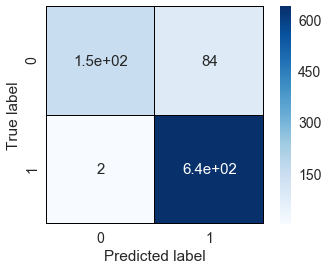

In [92]:
model.load_weights('Test4-Regularizer.weights.best.hdf5')
plot_confusion_matrix(model.predict_classes(x_val), y_val)

In [37]:
print(np.zeros([2, 2]))

[[0. 0.]
 [0. 0.]]


[[153, 100], [300, 900]]


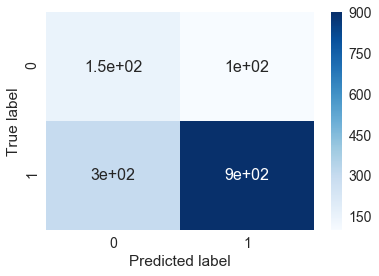

In [83]:


array2 = np.zeros([2, 2])
array = [
    [153,100],
     [300,900]]        
df_cm = pd.DataFrame(array, range(2), range(2))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(array)

[[153.  84.]
 [  2. 639.]]


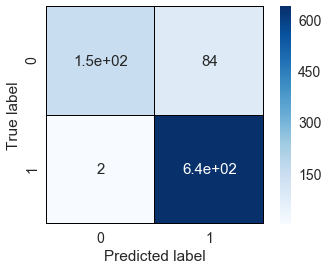

In [90]:
matrix = np.zeros([2, 2])
for i in range(x_val_predict.shape[0]):
    true_y = inverse_to_categorical(y_val[i])
    predict_y = x_val_predict[i]
    matrix[true_y][predict_y] = matrix[true_y][predict_y] + 1
    
df_cm = pd.DataFrame(matrix, range(2), range(2))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, cmap="Blues", linewidths=0.1, linecolor='Black', square=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(matrix)